In [1]:
# Importing all the necessary libraries
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [2]:
# Load Dataset
data = pd.read_csv("hate_speech_dataset.csv")
data.shape

(24783, 7)

In [3]:
# Printing the Sample Data
print("Sample Data (first 5 rows):")
data.head()

Sample Data (first 5 rows):


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
print("Sample Data (last 5 rows):")
data.tail()

Sample Data (last 5 rows):


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies
24782,25296,3,0,0,3,2,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


In [5]:
# Map classes -> binary labels
data['label'] = data['class'].map(lambda x: "Hate" if x == 0 else "Not-Hate")

In [6]:
# Preprocessing Function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', str(text), flags=re.MULTILINE) # remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    text = text.lower() # convert to lowercase
    text = re.sub(r'\d+', '', text) # remove numbers
    return text
data['cleaned_text'] = data['tweet'].apply(clean_text)

In [7]:
# Feature Extraction (TF-IDF)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(data['cleaned_text'])
y = data['label']

In [8]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Applying SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", dict(pd.Series(y_train).value_counts()))
print("After SMOTE:", dict(pd.Series(y_train_resampled).value_counts()))

Before SMOTE: {'Not-Hate': 18682, 'Hate': 1144}
After SMOTE: {'Not-Hate': 18682, 'Hate': 18682}


In [10]:
# Training the Model
model = LogisticRegression(max_iter=300)
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=300)

Accuracy: 0.8785555779705467

Classification Report:
               precision    recall  f1-score   support

    Not-Hate       0.27      0.65      0.38       286
        Hate       0.98      0.89      0.93      4671

    accuracy                           0.88      4957
   macro avg       0.62      0.77      0.66      4957
weighted avg       0.94      0.88      0.90      4957



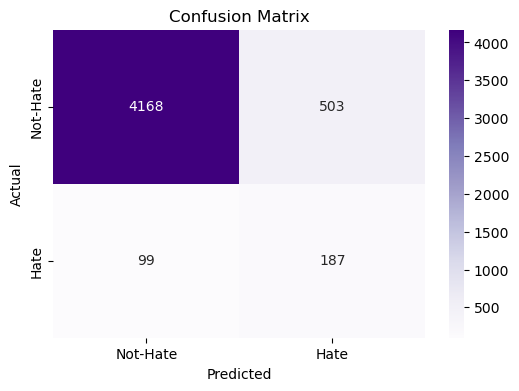

In [11]:
# Evaluation
y_pred = model.predict(X_test)
# Printing Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Not-Hate", "Hate"]))
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=["Not-Hate", "Hate"])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Purples", xticklabels=['Not-Hate', 'Hate'], yticklabels=['Not-Hate', 'Hate'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# Function to detect if a sentence is hate sentence
def predict_sentence(sentence):
    cleaned = clean_text(sentence)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    return prediction
# Testing on custom sentences
test_sentences = [
    "I hate you so much!",
    "Have a great day my friend!",
    "You are worthless and stupid",
    "I love this community, everyone is kind"
]
# Printing detections
for sent in test_sentences:
    print(f"Text: {sent} --> Detected as: {predict_sentence(sent)}")

Text: I hate you so much! --> Detected as: Hate
Text: Have a great day my friend! --> Detected as: Not-Hate
Text: You are worthless and stupid --> Detected as: Hate
Text: I love this community, everyone is kind --> Detected as: Not-Hate
